## Imports and settings

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
import pprint

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
import pprint
from scipy.stats import gaussian_kde

detector_path = '..'
results_path = os.path.join(detector_path, 'results')
sys.path.append(detector_path)

from utils import constants
from utils import errors
from sleep.mass import MASS
from sleep.mass_k import MASSK
from sleep.inta import INTA
from sleep import postprocessing
from sleep import data_ops
from evaluation import metrics
from evaluation import data_manipulation

SEED = 123
DPI = 200

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Load database and predicted probabilities

In [14]:
# Select database
dataset_name = 'massk'
# Select predictions ckpt folder

# Best ones:
# MASS: ckpt_folder = os.path.join('20190325_v2bn_fixed_loading_train_mass', 'bsf_avg')
# INTA: ckpt_folder = os.path.join('20190328_v2bn_fixed_inta_train_inta', 'bsf_avg')
ckpt_folder = os.path.join('20190413_bsf_kc_using_angle_train_massk', 'bsf', 'avg')
verbose = False

# Load data

# Marks are binary sequences for each page, 200 fs resolution
errors.check_valid_value(
    dataset_name, 'dataset_name',
    [constants.MASS_NAME, constants.INTA_NAME, 'massk'])
if dataset_name == constants.MASS_NAME:
    dataset = MASS(load_checkpoint=True)
elif dataset_name == constants.INTA_NAME:
    dataset = INTA(load_checkpoint=True)
else:
    dataset = MASSK(load_checkpoint=True)
    
    # Get training set ids
print('Loading train set and splitting train/val')
all_train_ids = dataset.train_ids
# Split to form validation set
train_ids, val_ids = data_manipulation.split_ids_list(
    all_train_ids, seed=SEED)
print('Training set IDs:', train_ids)
print('Validation set IDs:', val_ids)
# Get test data
print('Loading test set')
test_ids = dataset.test_ids
print('Testing set IDs:', test_ids)

# Get subjects data, with the expert used for training
print('Loading signals and marks')
# set_list = ['train', 'val', 'test']
set_list = ['test']
x = {}
y = {}
pages = {}
x['train'], y['train'] = dataset.get_subset_data(train_ids, which_expert=1, verbose=verbose)
x['val'], y['val'] = dataset.get_subset_data(val_ids, which_expert=1, verbose=verbose)
x['test'], y['test'] = dataset.get_subset_data(test_ids, which_expert=1, verbose=verbose)
print('Loading pages')
pages['train'] = dataset.get_subset_pages(train_ids, verbose=verbose)
pages['val'] = dataset.get_subset_pages(val_ids, verbose=verbose)
pages['test'] = dataset.get_subset_pages(test_ids, verbose=verbose)

# Load predictions (probability vectors for each page), 200/factor resolution (default factor 8)
ckpt_path = os.path.abspath(os.path.join(results_path, 'predictions_%s' % dataset_name, ckpt_folder))
print('Loading predictions from %s' % ckpt_path)
y_pred = {}
for set_name in set_list:
    y_pred[set_name] = np.load(os.path.join(ckpt_path, 'y_pred_%s.npy' % set_name), allow_pickle=True)
    # Keep only class 1 probability
    y_pred[set_name] = [this_y_pred[..., 1] for this_y_pred in y_pred[set_name]]
print('Done')

Dataset mass_k with 15 patients.
Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
A checkpoint doesn't exist at /home/ntapia/projects/repos/ssdetection-rnn/data/ckpt_mass_k/mass_k.pickle. Loading from files instead.
15 records in mass_k dataset.
Subject IDs: [1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 17, 18, 19]

Loading ID 1
Channel extracted: EEG C3-CLE
N2 pages: 745
Marks (K) from E1: 409
Loaded ID 1 (01/15 ready). Time elapsed: 1.8979 [s]

Loading ID 2
Channel extracted: EEG C3-CLE
N2 pages: 911
Marks (K) from E1: 637
Loaded ID 2 (02/15 ready). Time elapsed: 4.2098 [s]

Loading ID 3
Channel extracted: EEG C3-CLE
N2 pages: 496
Marks (K) from E1: 533
Loaded ID 3 (03/15 ready). Time elapsed: 6.7843 [s]

Loading ID 5
Channel extracted: EEG C3-CLE
N2 pages: 633
Marks (K) from E1: 419
Loaded ID 5 (04/15 ready). Time elapsed: 8.7710 [s]

Loading ID 6
Channel extracted: EEG C3-CLE
N2 pages: 676
Marks (K) from E1: 674
Load

In [16]:
# Prepare expert labels into marks
print('Preparing labels... ', end='', flush=True)
y_stamps = {}
for set_name in set_list:
    y_stamps[set_name] = postprocessing.generate_mark_intervals_with_list(
        y[set_name], pages[set_name], 200, 200, thr=None, postprocess=False)
print('Done')

Preparing labels... Done


In [4]:
# Load second expert in mass
y2 = {}
if dataset_name == constants.MASS_NAME:
    _, y2['train'] = dataset.get_subset_data(train_ids, which_expert=2, verbose=verbose)
    _, y2['val'] = dataset.get_subset_data(val_ids, which_expert=2, verbose=verbose)
    _, y2['test'] = dataset.get_subset_data(test_ids, which_expert=2, verbose=verbose)
print('Preparing labels of E2... ', end='', flush=True)
y2_stamps = {}
for set_name in set_list:
    y2_stamps[set_name] = postprocessing.generate_mark_intervals_with_list(
        y2[set_name], pages[set_name], 200, 200, thr=None, postprocess=False)
print('Done')

Preparing labels of E2... Done


## Performance: F1 vs IoU curve

In [17]:
# Performance settings
chosen_set = 'test'
thr = 0.48

# ---------------- Compute performance
print('Using thr %1.4f and %s set' % (thr, chosen_set))

# Prepare expert labels into marks
y_thr = y_stamps[chosen_set]

# Prepare model predictions
print('Preparing predictions', flush=True)
y_pred_thr = postprocessing.generate_mark_intervals_with_list(
    y_pred[chosen_set], pages[chosen_set], 200//8, 200, thr=thr)
n_subjects = len(y_thr)

# Go through several IoU values
print('Computing F1 Curve', flush=True)
iou_list = np.arange(1, 10) * 0.1
all_f1_list = [metrics.f1_vs_iou(this_y, this_y_pred, iou_list) 
               for (this_y, this_y_pred) 
               in zip(y_thr, y_pred_thr)]
all_f1_list = np.stack(all_f1_list, axis=1)
mean_f1 = np.mean(all_f1_list, axis=1)
std_f1 = np.std(all_f1_list, axis=1)
    
model_f1_mean = np.stack([iou_list, mean_f1], axis=1)
model_f1_std = np.stack([iou_list, std_f1], axis=1)
print('Mean F1')
pprint.pprint(model_f1_mean)
print('Std F1')
pprint.pprint(model_f1_std)

Using thr 0.4800 and test set
Preparing predictions
Computing F1 Curve
Mean F1
array([[0.1       , 0.82623973],
       [0.2       , 0.82388061],
       [0.3       , 0.81947004],
       [0.4       , 0.8101793 ],
       [0.5       , 0.78406803],
       [0.6       , 0.76657073],
       [0.7       , 0.7421336 ],
       [0.8       , 0.69122011],
       [0.9       , 0.50025414]])
Std F1
array([[0.1       , 0.04094795],
       [0.2       , 0.04061842],
       [0.3       , 0.03966787],
       [0.4       , 0.03969413],
       [0.5       , 0.03798476],
       [0.6       , 0.0327493 ],
       [0.7       , 0.03230668],
       [0.8       , 0.02846757],
       [0.9       , 0.03292317]])


In [ ]:
# Single metric: average F1 on validation set at threshold 0.5
chosen_set_af1 = 'val'
validation_af1 = metrics.average_f1_with_list(
    y[chosen_set_af1], y_pred[chosen_set_af1], pages[chosen_set_af1])
print('%s AF1: %1.4f' % (chosen_set_af1.capitalize(), validation_af1))

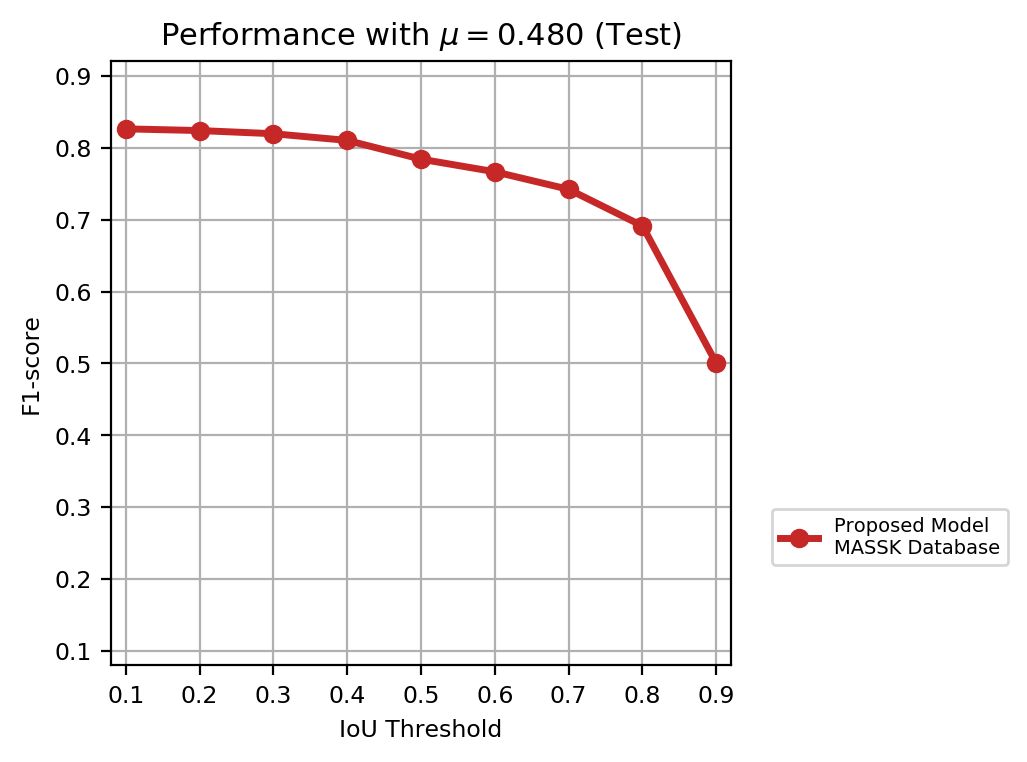

In [18]:
# Saving settings
save_f1_iou_result = True
ckpt_id = '20190413_kcomplex_bsf_avg'

# Comparison settings
comparison_folder = 'comparison_data'
compare_expert = False
compare_chambon = False
show_set_std = False
alpha = 0.2
color_list = {'model': '#c62828', 'expert': '#455a64', 'chambon': '#0277bd'} 
zoom_xlim = [0.1, 0.7]
zoom_ylim = [0.6, 0.85]
linewidth_model = 2.5
markersize_model = 12
linewidth_others = 1.5
markersize_others = 8

# --------------- Optional: Save F1 data
if save_f1_iou_result:
    filename = os.path.join('comparison_data', '%s_f1_vs_iou_model_%s.csv' % (dataset_name, ckpt_id))
    np.savetxt(filename, model_f1_mean, delimiter=",")


# -------------------- P L O T ----------------------    
# Comparison data
if compare_expert:
    expert_f1_curve_mean = np.loadtxt(os.path.join(comparison_folder, 'f1_vs_iou_expert_mean.csv'), delimiter=',')
    expert_f1_curve_std = np.loadtxt(os.path.join(comparison_folder, 'f1_vs_iou_expert_std.csv'), delimiter=',')
if compare_chambon:
    chambon_f1_curve = np.loadtxt(os.path.join(comparison_folder, 'mass_f1_vs_iou_Chambon.csv'), delimiter=',')

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=DPI)

# Complete plot
if compare_expert:
    ax.plot(expert_f1_curve_mean[1:, 0], expert_f1_curve_mean[1:, 1], linewidth=linewidth_others, 
               markersize=markersize_others, marker='.', 
               label='Expert Performance\nPrivate Database\nWarby et al. 2014', color=color_list['expert'])
    ax.fill_between(
        expert_f1_curve_mean[1:, 0], 
        expert_f1_curve_mean[1:, 1] - expert_f1_curve_std[1:, 1], 
        expert_f1_curve_mean[1:, 1] + expert_f1_curve_std[1:, 1], 
        alpha=alpha, facecolor=color_list['expert'])
if compare_chambon:
    ax.plot(chambon_f1_curve[:, 0], chambon_f1_curve[:, 1], linewidth=linewidth_others, 
               markersize=markersize_others, marker='.', 
               label='DOSED (ConvNet)\nMASS Database\nChambon et al. 2018', color=color_list['chambon'])
ax.plot(model_f1_mean[:, 0], model_f1_mean[:, 1], 
           linewidth=linewidth_model, markersize=markersize_model, marker='.', 
           label='Proposed Model\n%s Database' % dataset_name.upper(), color=color_list['model'])
if show_set_std:
    ax.fill_between(
            model_f1_mean[:, 0], 
            model_f1_mean[:, 1] - model_f1_std[:, 1], 
            model_f1_mean[:, 1] + model_f1_std[:, 1], 
            alpha=alpha, facecolor=color_list['model'])
ax.set_title('Performance with $\mu=%1.3f$ (%s)' % (thr, chosen_set.capitalize()), fontsize=11)
ax.set_xlim([0.08, 0.92])
ax.set_ylim([0.08, 0.92])
ax.set_yticks([0.1*i for i in range(1, 10)])
ax.set_xticks([0.1*i for i in range(1, 10)])
ax.tick_params(labelsize=8.5)
ax.set_xlabel('IoU Threshold', fontsize=8.5)
ax.set_ylabel('F1-score', fontsize=8.5)
ax.grid()

# # Zoom plot
# if compare_expert:
#     ax[1].plot(expert_f1_curve_mean[1:, 0], expert_f1_curve_mean[1:, 1], 
#                linewidth=linewidth_others, markersize=markersize_others, marker='.', 
#                label='Expert Performance\nPrivate Database\nWarby et al. 2014', 
#                color=color_list['expert'])
#     ax[1].fill_between(
#         expert_f1_curve_mean[1:, 0], 
#         expert_f1_curve_mean[1:, 1] - expert_f1_curve_std[1:, 1], 
#         expert_f1_curve_mean[1:, 1] + expert_f1_curve_std[1:, 1], 
#         alpha=alpha, facecolor=color_list['expert'])
# if compare_chambon:
#     ax[1].plot(chambon_f1_curve[:, 0], chambon_f1_curve[:, 1], 
#                linewidth=linewidth_others, markersize=markersize_others, marker='.', 
#                label='DOSED (ConvNet)\nMASS Database\nChambon et al. 2018', color=color_list['chambon'])
# ax[1].plot(model_f1_mean[:, 0], model_f1_mean[:, 1], 
#            linewidth=linewidth_model, markersize=markersize_model, marker='.', 
#            label='Proposed Model\n%s Database' % dataset_name.upper(), color=color_list['model'])
# if show_set_std:
#     ax[1].fill_between(
#             model_f1_mean[:, 0], 
#             model_f1_mean[:, 1] - model_f1_std[:, 1], 
#             model_f1_mean[:, 1] + model_f1_std[:, 1], 
#             alpha=alpha, facecolor=color_list['model'])
# ax[1].set_title('Zoom in', fontsize=11)
# ax[1].set_xlim(zoom_xlim)
# ax[1].set_ylim(zoom_ylim)
# ax[1].set_xlabel('IoU Threshold', fontsize=8.5)
# # ax[1].set_ylabel('F1-score')
# ax[1].tick_params(labelsize=8.5)
# ax[1].legend(loc='lower left', bbox_to_anchor=(1.05, 0.15), labelspacing=3, fontsize=8.5)
# ax[1].grid()

ax.legend(loc='lower left', bbox_to_anchor=(1.05, 0.15), labelspacing=3, fontsize=7)

plt.show()

## Performance: Precision-Recall plot, separated subjects

In [23]:
thr = 0.48

iou_thr = 0.3

# Prepare model predictions
be_stats = {}
for set_name in set_list:
    print('Preparing predictions for %s set' % set_name, flush=True)
    y_pred_thr = postprocessing.generate_mark_intervals_with_list(
        y_pred[set_name], pages[set_name], 200//8, 200, thr=thr)
    be_stats[set_name] = [metrics.by_event_confusion(this_y, this_y_pred, iou_thr=iou_thr) 
                for (this_y, this_y_pred) in zip(y_stamps[set_name], y_pred_thr)]
    print('Done')

Preparing predictions for test set
Done


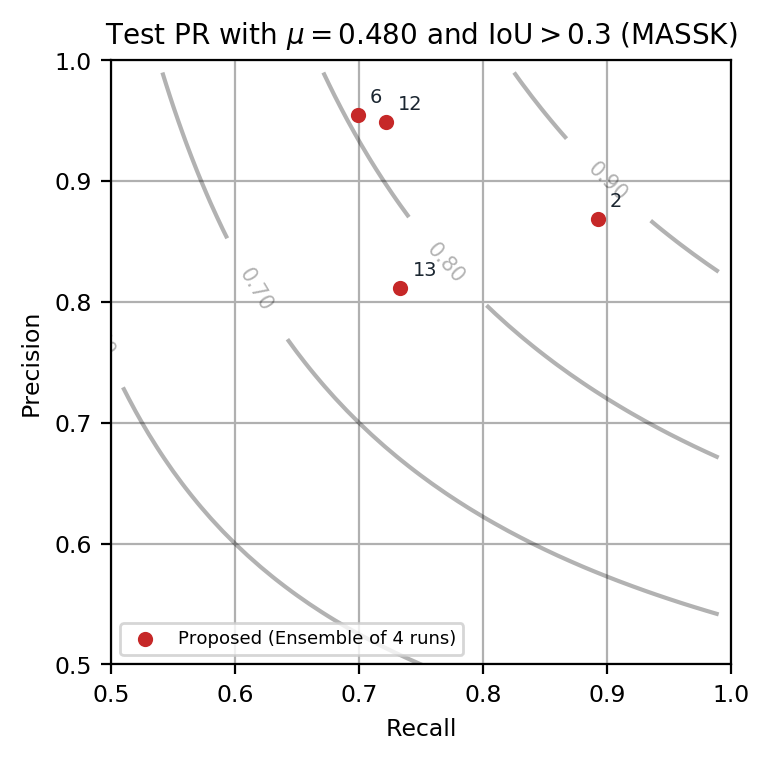

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=DPI)
text_space = 0.01
markersize = 20

# F1 score levels
delta = 0.01 
x_ = np.arange(1, 100) * delta 
y_ = np.arange(1, 100) * delta 
X, Y = np.meshgrid(x_, y_)
Z = 2 * X * Y / (X + Y)
CS = ax.contour(X, Y, Z, colors='k', alpha=0.3, levels=[0.6, 0.7, 0.8, 0.9])
ax.clabel(CS, fontsize=7.5, fmt='%1.2f')

# Scatter plots of each subject
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
color_list = {'train':'#43a047', 'val':'#0288d1', 'test': '#c62828'}
for set_name in set_list:
    for i, stats in enumerate(be_stats[set_name]):
        if i==0:
            ax.scatter(stats['recall'], stats['precision'], c=color_list[set_name], label='Proposed (Ensemble of 4 runs)', s=markersize, zorder=10)
        else:
            ax.scatter(stats['recall'], stats['precision'], c=color_list[set_name], s=markersize, zorder=10)
        ax.annotate(idx_dict[set_name][i], (stats['recall']+text_space, stats['precision']+text_space), fontsize=7, color='#1b2631', zorder=20)  

ax.set_title('Test PR with $\mu=%1.3f$ and IoU$>$%1.1f (%s)' % (thr, iou_thr, dataset_name.upper()), fontsize=10)
ax.set_xlabel('Recall', fontsize=8.5)
ax.set_ylabel('Precision', fontsize=8.5)
ax.set_xlim([0.5, 1])
ax.set_ylim([0.5, 1])
ax.legend(loc='lower left', fontsize=6.5)
ax.tick_params(labelsize=8.5)
ax.grid()
plt.show()

## Performance: Precision-Recall curve, average per set

In [25]:
# The mean of each set is drawn, for several thr

iou_thr = 0.3
thr_list = [0.1, 0.2, 0.3, 0.4, 0.48, 0.5, 0.6, 0.7, 0.8, 0.9]
# thr_list = [0.05*i for i in range(1, 20)]

# Prepare model predictions
pr_curve = {}
n_thr = len(thr_list)
for set_name in set_list:
    print('Processing %s set' % set_name, flush=True)
    pr_curve[set_name] = np.zeros((n_thr, 2))   # Columns are [x: recall, y: precision]
    for i, thr in enumerate(thr_list):
        print('Processing threshold %1.2f' % thr, flush=True)
        y_pred_thr = postprocessing.generate_mark_intervals_with_list(
            y_pred[set_name], pages[set_name], 200//8, 200, thr=thr)
        this_stats = [metrics.by_event_confusion(this_y, this_y_pred, iou_thr=iou_thr) 
                    for (this_y, this_y_pred) in zip(y_stamps[set_name], y_pred_thr)]
        this_recall = np.mean([m['recall'] for m in this_stats])
        this_precision = np.mean([m['precision'] for m in this_stats])
        pr_curve[set_name][i, 0] = this_recall
        pr_curve[set_name][i, 1] = this_precision
    print('Done', flush=True)    

Processing test set
Processing threshold 0.10
Processing threshold 0.20
Processing threshold 0.30
Processing threshold 0.40
Processing threshold 0.48
Processing threshold 0.50
Processing threshold 0.60
Processing threshold 0.70
Processing threshold 0.80
Processing threshold 0.90
Done


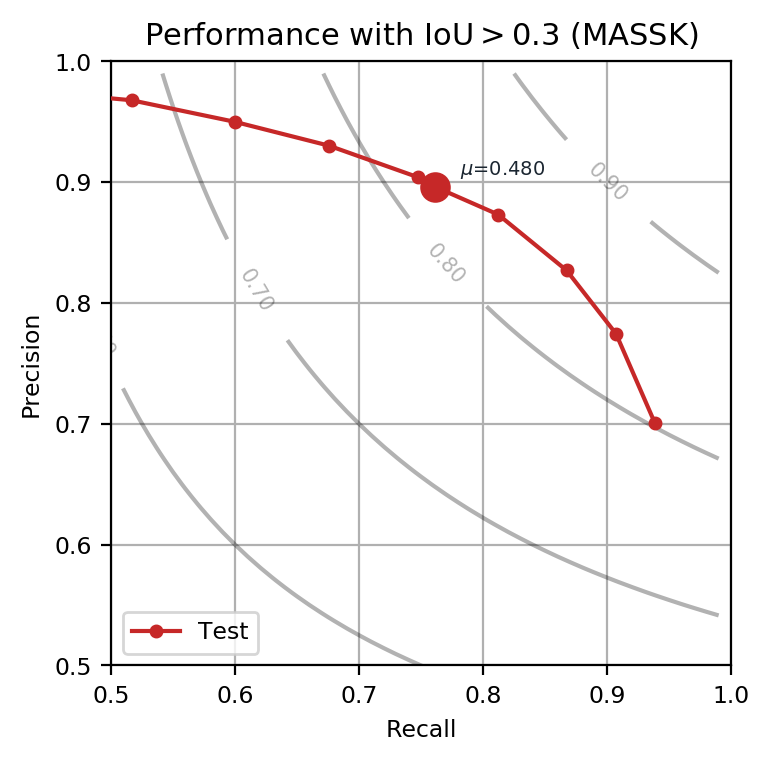

In [26]:
# Plot settings
show_train = False
show_val = False

thr_to_show = 0.48

# ---------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=DPI)
markersize = 8

# F1 score levels
delta = 0.01 
x_ = np.arange(1, 100) * delta 
y_ = np.arange(1, 100) * delta 
X, Y = np.meshgrid(x_, y_)
Z = 2 * X * Y / (X + Y)
CS = ax.contour(X, Y, Z, colors='k', alpha=0.3, levels=[0.6, 0.7, 0.8, 0.9])
ax.clabel(CS, fontsize=7.5, fmt='%1.2f')

set_list_aux = []
if show_train:
    set_list_aux.append('train')
if show_val:
    set_list_aux.append('val')
set_list_aux.append('test')

# Scatter plots of each subset
half_thr_idx = thr_list.index(thr_to_show)
color_list = {'train':'#43a047', 'val':'#0288d1', 'test': '#c62828'}
for i, set_name in enumerate(set_list_aux):
    ax.plot(pr_curve[set_name][:, 0], pr_curve[set_name][:, 1], 
            label=set_name.capitalize(), markersize=markersize, marker='.', 
            linewidth=1.5, color=color_list[set_name], zorder=10*(i+1))
# Highlight threshold=0.5
for i, set_name in enumerate(set_list_aux):
    ax.scatter(pr_curve[set_name][half_thr_idx, 0], pr_curve[set_name][half_thr_idx, 1], 
               s=100, c=color_list[set_name], zorder=10*(i+1))
    ax.annotate('$\mu$=%1.3f' % thr_to_show, (pr_curve[set_name][half_thr_idx, 0] + text_space*2, pr_curve[set_name][half_thr_idx, 1] + text_space), fontsize=7, color='#1b2631', zorder=20)  

ax.set_title('Performance with IoU$>$%1.1f (%s)' % (iou_thr, dataset_name.upper()), fontsize=11)
ax.set_xlabel('Recall', fontsize=8.5)
ax.set_ylabel('Precision', fontsize=8.5)
ax.set_xlim([0.5, 1])
ax.set_ylim([0.5, 1])
ax.legend(loc='lower left', fontsize=8.5)
ax.tick_params(labelsize=8.5)
ax.grid()
plt.show()

## Visualization of subject

In [31]:
thr = 0.48

subset_name = 'test'
subject_id = 2

# -----

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
idx_subject = idx_dict[subset_name].index(subject_id)
this_signal = x[subset_name][idx_subject]
this_marks_1 = y[subset_name][idx_subject]
this_n2_pages = pages[subset_name][idx_subject]
this_prob = y_pred[subset_name][idx_subject]
if dataset_name == constants.MASS_NAME:
    _, this_marks_2 = dataset.get_subject_data(subject_id, which_expert=2, verbose=True)
    channel_name = 'C3-CLE'
elif dataset_name == constants.INTA_NAME:
    channel_name = 'F4-C4'
else:
    channel_name = 'C3-CLE'
    
y_pred_thr = postprocessing.generate_mark_intervals(
    y_pred[subset_name][idx_subject], pages[subset_name][idx_subject], 200//8, 200, thr=thr)
y_pred_thr_seq = data_ops.inter2seq(y_pred_thr, 0, (pages[subset_name][idx_subject].max()+1)*200*20-1)
# Now reshape into pages
this_det = data_ops.extract_pages(y_pred_thr_seq, pages[subset_name][idx_subject], 200*20, border_size=0)
    
# make a color map of fixed colors
cmap = colors.ListedColormap(['white', '#c62828'])

def plot_page(page_idx):
    if dataset_name == constants.MASS_NAME:
        fig = plt.figure(figsize=(15, 5), dpi=DPI)
        gs = gridspec.GridSpec(4, 1, height_ratios=[4, 1, 1, 1])
    else:
        fig = plt.figure(figsize=(15, 4), dpi=DPI)
        gs = gridspec.GridSpec(3, 1, height_ratios=[4, 1, 1])
    
    page_idx = page_idx - 1
    
    segment_signal = this_signal[page_idx, :]
    segment_marks_1 = this_marks_1[page_idx, :]
    segment_prob = this_prob[page_idx, :]
    segment_det = this_det[page_idx, :]
    time_axis = np.arange(this_signal.shape[1]) / dataset.fs
    
    if dataset_name == constants.MASS_NAME:
        segment_marks_2 = this_marks_2[page_idx, :]
    
    gs_idx = 0
    
    # Signal
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    ax.plot(time_axis, segment_signal, linewidth=1, color='#455a64')
    ax.set_yticks([])
    ax.set_xlim([0, 20])
    ax.set_ylim([-10, 10])
    ax.set_title('Subject %d (%s-%s). %s EEG channel. Page in record: %d (intervals of 0.5s are shown)' 
                 % (subject_id, dataset_name.upper(), subset_name.capitalize(), channel_name, this_n2_pages[page_idx]), fontsize=10)
    ax.set_xticks([0, 5, 10, 15, 20])
    ax.set_xticks(np.arange(0, 20, 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    ax.tick_params(labelsize=8.5)
    
    # Expert mark
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    ax.imshow(segment_marks_1[np.newaxis, :], interpolation=None, aspect='auto', cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Expert ground truth (red indicates event)', fontsize=10)
    
    # Neural net
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    ax.plot(segment_prob, color='#c62828', linewidth=1.5)
    ax.fill_between(np.arange(500), segment_det[::8], facecolor='k', alpha=0.3)
    ax.set_xticks([])
    ax.set_ylim([-0.1, 1.1])
    ax.set_xlim([0, 500])
    ax.set_yticks([0, 1])
    ax.set_yticks([thr], minor=True)
    ax.grid(b=True, axis='y', linewidth=1.5, which='minor')
    ax.tick_params(labelsize=8.5)
    ax.set_title('Model probability prediction (%1.2f threshold and postprocessed detections are shown)' % thr, fontsize=10)
    
    if dataset_name == constants.MASS_NAME:
        ax = fig.add_subplot(gs[gs_idx])
        ax.imshow(segment_marks_2[np.newaxis, :], interpolation=None, aspect='auto', cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Second expert, not used for training (red indicates event)', fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [32]:
widgets.interact(
    lambda page_idx: plot_page(page_idx),
    page_idx=widgets.IntSlider(min=1,max=this_n2_pages.shape[0],step=1,value=1, continuous_update=False));

interactive(children=(IntSlider(value=1, continuous_update=False, description='page_idx', max=911, min=1), Out…

# Error analysis

### Postprocessing sensitivity

In [5]:
chosen_set_error = 'test'
thr = 0.45

y_thr = y_stamps[chosen_set_error]

# Prepare model predictions
n_subjects = len(y_thr)
pred_stamps = []
for i in range(n_subjects):
    print('Processing subject %d/%d' % (i+1, n_subjects), flush=True)
    # Binarize
    this_y_pred_thr = (y_pred[chosen_set_error][i] >= thr).astype(np.int32)
    # Transform to intervals
    this_y_pred_thr = data_ops.seq2inter_with_pages(
        this_y_pred_thr, pages[chosen_set_error][i]
    )
    pred_stamps.append(this_y_pred_thr)
fs_pred = 200 // 8 
fs_real = 200
print('Done')

Processing subject 1/4
Processing subject 2/4
Processing subject 3/4
Processing subject 4/4
Done


In [ ]:
# ------------------------- Compute spacing ----------------------
combine_thr = 0.3

spacing = []
spacing_expert = []
for i in range(n_subjects):
    print('Spacing for subject %d/%d' % (i+1, n_subjects), flush=True)
    this_spacing = (pred_stamps[i][1:, 0] - pred_stamps[i][:-1, 1]) / fs_pred
    this_spacing_expert = (y_stamps[chosen_set_error][i][1:, 0] - y_stamps[chosen_set_error][i][:-1, 1]) / fs_real
    # Only consider for this analysis, spacing less than one second
    this_spacing = this_spacing[this_spacing < 1]
    this_spacing_expert = this_spacing_expert[this_spacing_expert < 1]
    spacing.append(this_spacing)
    spacing_expert.append(this_spacing_expert)
print('Done')

fig, ax = plt.subplots(n_subjects, 2, figsize=(8, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0, 0].set_title('Spacing between nearby expert marks', fontsize=10)
ax[0, 1].set_title('Spacing between nearby detections', fontsize=10)
y_max = 0
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # Real
    n_real, _, _ = ax[i, 0].hist(spacing_expert[i], bins=[k*0.1 for k in range(11)], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 0].set_xticks([k*0.2 for k in range(6)])
    ax[i, 0].tick_params(labelsize=8.5)
    ax[i, 0].legend(fontsize=8.5)
    # Predicted
    n_pred, _, _ = ax[i, 1].hist(spacing[i], bins=[k*0.1 for k in range(11)], color='#c62828', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 1].set_xticks([k*0.2 for k in range(6)])
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5)
    max_y = max(np.max(n_real), np.max(n_pred))
    ax[i, 0].plot([combine_thr, combine_thr], [0, max_y], '--', color='k', linewidth=2, alpha=0.6)
    ax[i, 1].plot([combine_thr, combine_thr], [0, max_y], '--', color='k', linewidth=2, alpha=0.6)
    # y_max = max(max_y, y_max)
# for i in range(n_subjects):
#     ax[i, 0].plot([combine_thr, combine_thr], [0, y_max], '--', color='k', linewidth=2, alpha=0.6)
#     ax[i, 1].plot([combine_thr, combine_thr], [0, y_max], '--', color='k', linewidth=2, alpha=0.6)
ax[-1, 0].set_xlabel('Spacing [s]', fontsize=8.5)
ax[-1, 1].set_xlabel('Spacing [s]', fontsize=8.5)
plt.show()

In [ ]:
# -------------- Durations

durations = []
durations_expert = []
for i in range(n_subjects):
    print('Durations for subject %d/%d' % (i+1, n_subjects), flush=True)
    # First, combine close marks
    this_pred_stamps = postprocessing.combine_close_marks(pred_stamps[i], fs_pred, combine_thr)
    # Now compute durations
    this_durations = (this_pred_stamps[:, 1] - this_pred_stamps[:, 0]) / fs_pred
    this_durations_expert = (y_stamps[chosen_set_error][i][:, 1] - y_stamps[chosen_set_error][i][:, 0]) / fs_real
    # Only consider for this analysis, spacing less than one second
    durations.append(this_durations)
    durations_expert.append(this_durations_expert)
print('Done')

fig, ax = plt.subplots(n_subjects, 2, figsize=(8, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0, 0].set_title('Duration of expert marks', fontsize=10)
ax[0, 1].set_title('Duration of detections', fontsize=10)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
y_max = 0
min_duration = 0.3  
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # Real
    n_real, _, _ = ax[i, 0].hist(durations_expert[i], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 0].tick_params(labelsize=8.5)
    ax[i, 0].legend(fontsize=8.5)
    # Predicted
    n_pred, _, _ = ax[i, 1].hist(durations[i], color='#c62828', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5)
    max_y = max(np.max(n_real), np.max(n_pred))
    ax[i, 0].plot([min_duration, min_duration], [0, max_y], '--', color='k', linewidth=2, alpha=0.6)
    ax[i, 1].plot([min_duration, min_duration], [0, max_y], '--', color='k', linewidth=2, alpha=0.6)
    y_max = max(max_y, y_max)
    
#for i in range(n_subjects):
#    ax[i, 0].plot([min_duration, min_duration], [0, y_max], '--', color='k', linewidth=2, alpha=0.6)
#    ax[i, 1].plot([min_duration, min_duration], [0, y_max], '--', color='k', linewidth=2, alpha=0.6)

ax[-1, 0].set_xlabel('Duration [s]', fontsize=8.5)
ax[-1, 1].set_xlabel('Duration [s]', fontsize=8.5)
plt.show()

### Location of Falses

In [7]:
iou_array = []
idx_array = []
y_pred_thr = []
for i in range(n_subjects):
    print('Processing subject %d/%d' % (i+1, n_subjects), flush=True)
    events = y_stamps[chosen_set_error][i]
    detections = postprocessing.generate_mark_intervals(
        y_pred[chosen_set_error][i], pages[chosen_set_error][i], 200//8, 200, thr=thr)
    print(events.shape, detections.shape)
    this_iou_array, this_idx_array = metrics.matching(events, detections)
    iou_array.append(this_iou_array)
    idx_array.append(this_idx_array)
    y_pred_thr.append(detections)
print('Done')

Processing subject 1/4
(1139, 2) (1153, 2)
Processing subject 2/4
(150, 2) (134, 2)
Processing subject 3/4
(706, 2) (622, 2)
Processing subject 4/4
(691, 2) (976, 2)
Done


In [ ]:
# --- False negatives
iou_thr = 0.3

fn_center = []
for i in range(n_subjects):
    idx_fn = iou_array[i] < iou_thr
    fn_stamps = y_stamps[chosen_set_error][i][idx_fn]
    this_fn_center = np.mean(fn_stamps, axis=1).astype(np.int32)
    fn_center.append(this_fn_center)
    
# --- False positives
fp_center = []
for i in range(n_subjects):
    # matched detections:
    idx_fp_1 = iou_array[i] < iou_thr
    idx_fp_1 = idx_array[i][idx_fp_1]
    idx_fp_1 = [idx for idx in idx_fp_1 if idx != -1]
    # Unmatched events
    n_detections = y_pred_thr[i].shape[0]
    idx_fp_2 = [idx for idx in range(n_detections) if (idx not in idx_array[i])]
    idx_fp = idx_fp_1 + idx_fp_2
    fp_stamps = y_pred_thr[i][idx_fp]
    this_fp_center = np.mean(fp_stamps, axis=1).astype(np.int32)
    fp_center.append(this_fp_center)

    
# --- Histogram of IoU values across real events
fig, ax = plt.subplots(n_subjects, 1, figsize=(3.5, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0].set_title('IoU values on expert marks', fontsize=10)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i].hist(iou_array[i], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), bins=[0.05*i for i in range(21)])
    ax[i].tick_params(labelsize=8.5)
    ax[i].legend(fontsize=8.5, loc='upper center')
    ax[i].set_xticks([0.2*i for i in range(6)])
ax[-1].set_xlabel('Time within page [s]', fontsize=8.5)
plt.show()
    
# --- Location in page
fn_loc_page = [np.mod(this_fn_center, 20*fs_real) for this_fn_center in fn_center]

fig, ax = plt.subplots(n_subjects, 2, figsize=(8, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0, 0].set_title('Location of expert marks with IoU < %1.2f' % (iou_thr), fontsize=11)

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i, 0].hist(fn_loc_page[i] / fs_real, bins=[i*4 for i in range(6)], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 0].tick_params(labelsize=8.5)
    ax[i, 0].legend(fontsize=8.5, loc='upper center')
ax[-1, 0].set_xticks([i*4 for i in range(6)])
ax[-1, 0].set_xlabel('Time within page [s]', fontsize=8.5)

fp_loc_page = [np.mod(this_fp_center, 20*fs_real) for this_fp_center in fp_center]

ax[0, 1].set_title('Location of detections with IoU < %1.2f' % (iou_thr), fontsize=10)

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i, 1].hist(fp_loc_page[i] / fs_real, bins=[i*4 for i in range(6)], color='#c62828', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5, loc='upper center')
ax[-1, 1].set_xticks([i*4 for i in range(6)])
ax[-1, 1].set_xlabel('Time within page [s]', fontsize=8.5)

plt.show()

# --- Location in register

fn_loc_register = [np.floor_divide(this_fn_center, 20*fs_real) for this_fn_center in fn_center]
max_page_array = [np.max(pages[chosen_set_error][i]) for i in range(n_subjects)]

max_of_all = np.max(max_page_array)

fig, ax = plt.subplots(n_subjects, 2, figsize=(8, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0, 0].set_title('Location in register of expert marks with IoU < %1.1f' % (iou_thr), fontsize=10)

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i, 0].hist(fn_loc_register[i], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 0].tick_params(labelsize=8.5)
    ax[i, 0].legend(fontsize=8.5)
ax[-1, 0].set_xlim([0, max_of_all+10])
ax[-1, 0].set_xlabel('Page within register', fontsize=8.5)

fp_loc_register = [np.floor_divide(this_fp_center, 20*fs_real) for this_fp_center in fp_center]
max_page_array = [np.max(pages[chosen_set_error][i]) for i in range(n_subjects)]

max_of_all = np.max(max_page_array)

ax[0, 1].set_title('Location in register of detections with IoU < %1.1f' % (iou_thr), fontsize=11)

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i, 1].hist(fp_loc_register[i], color='#c62828', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5)
ax[-1, 1].set_xlim([0, max_of_all+10])
ax[-1, 1].set_xlabel('Page within register', fontsize=8.5)

plt.show()

# ----- N2 pages

fig, ax = plt.subplots(n_subjects, 1, figsize=(3.5, 1*n_subjects), dpi=DPI, sharex=True, sharey=True)
ax[0].set_title('Location in register of N2 pages (%s)' % (chosen_set_error.capitalize()), fontsize=10)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i].hist(pages[chosen_set_error][i], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i].tick_params(labelsize=8.5)
    ax[i].legend(fontsize=8.5)
ax[-1].set_xlim([0, max_of_all+10])
ax[-1].set_xlabel('Page within register', fontsize=8.5)

plt.show()

### IoU vs Duration

In [ ]:
# --- Scatter of IoU values and duration of real and detected events
alpha = 0.2
markersize=10

fig, ax = plt.subplots(n_subjects, 2, figsize=(7, 1*n_subjects), dpi=DPI, sharex=True, sharey=True)
ax[0, 0].set_title('IoU vs duration of expert marks', fontsize=10)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # Now compute durations
    this_durations_expert = (y_stamps[chosen_set_error][i][:, 1] - y_stamps[chosen_set_error][i][:, 0]) / fs_real
    ax[i, 0].scatter(this_durations_expert, iou_array[i], label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), color='#455a64', alpha=alpha, s=markersize)
    ax[i, 0].tick_params(labelsize=8.5)
    lg = ax[i, 0].legend(fontsize=7, loc='lower right')
    for lh in lg.legendHandles:
        lh.set_facecolor(lh.get_facecolor())
        lh.set_edgecolor(lh.get_edgecolor())
        lh.set_alpha(1.0)
    ax[i, 0].set_ylabel('IoU', fontsize=8.5)
ax[-1, 0].set_xlabel('Duration [s]', fontsize=8.5)

ax[0, 1].set_title('IoU vs duration of detections', fontsize=10)
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # Now compute durations for IoU > 0 
    idx_valid = (idx_array[i] > -1)
    this_iou_1 = iou_array[i][idx_valid]
    y_pred_stamps = y_pred_thr[i][idx_array[i]][idx_valid]
    this_durations_1 = (y_pred_stamps[:, 1] - y_pred_stamps[:, 0]) / fs_real
    # Now durations for IoU = 0
    n_detections = y_pred_thr[i].shape[0]
    idx_fp_2 = [idx for idx in range(n_detections) if (idx not in idx_array[i])]
    y_pred_stamps = y_pred_thr[i][idx_fp_2]
    this_durations_2 = (y_pred_stamps[:, 1] - y_pred_stamps[:, 0]) / fs_real
    this_iou_2 = np.zeros(this_durations_2.shape[0])
    # Concatenation
    this_durations = np.concatenate([this_durations_1, this_durations_2])
    this_iou = np.concatenate([this_iou_1, this_iou_2])
    ax[i, 1].scatter(this_durations, this_iou, label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), color='#c62828', alpha=alpha, s=markersize)
    ax[i, 1].tick_params(labelsize=8.5)
    lg = ax[i, 1].legend(fontsize=7, loc='lower right')
    for lh in lg.legendHandles:
        lh.set_facecolor(lh.get_facecolor())
        lh.set_edgecolor(lh.get_edgecolor())
        lh.set_alpha(1.0)
    # ax[i, 1].set_ylabel('IoU', fontsize=8.5)
ax[-1, 1].set_xlabel('Duration [s]', fontsize=8.5)

plt.show()


# --- Histogram of duration for IoU == 0
fig, ax = plt.subplots(n_subjects, 2, figsize=(8, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0, 0].set_title('Duration of unpaired expert marks', fontsize=10)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # Now compute durations
    this_durations_expert = (y_stamps[chosen_set_error][i][:, 1] - y_stamps[chosen_set_error][i][:, 0]) / fs_real
    idx_zero = (iou_array[i] == 0)
    this_durations_expert_fn = this_durations_expert[idx_zero]
    ax[i, 0].hist(this_durations_expert_fn, label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), color='#455a64')
    ax[i, 0].tick_params(labelsize=8.5)
    lg = ax[i, 0].legend(fontsize=8.5, loc='upper right')
    
ax[-1, 0].set_xlabel('Duration [s]', fontsize=8.5)

ax[0, 1].set_title('Duration of unpaired detections', fontsize=10)
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    n_detections = y_pred_thr[i].shape[0]
    idx_fp_2 = [idx for idx in range(n_detections) if (idx not in idx_array[i])]
    y_pred_stamps = y_pred_thr[i][idx_fp_2]
    this_durations_fp = (y_pred_stamps[:, 1] - y_pred_stamps[:, 0]) / fs_real
    ax[i, 1].hist(this_durations_fp, label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), color='#c62828')
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5, loc='upper right')
ax[-1, 1].set_xlabel('Duration [s]', fontsize=8.5)

plt.show()


### Duration of events and matched detections

In [ ]:
alpha = 0.2

fig, ax = plt.subplots(2, 2, figsize=(5, 5), dpi=DPI, sharex=True, sharey=True)
# plt.suptitle('Duration of matched events (%s)' % (chosen_set_error.capitalize()), fontsize=11)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    idx_valid = (idx_array[i] > -1)
    # Now compute durations for real
    this_durations_expert = (y_stamps[chosen_set_error][i][:, 1] - y_stamps[chosen_set_error][i][:, 0]) / fs_real
    this_durations_expert = this_durations_expert[idx_valid]
    # Now compute durations for matched detections
    y_pred_stamps = y_pred_thr[i][idx_array[i]][idx_valid]
    this_durations_det = (y_pred_stamps[:, 1] - y_pred_stamps[:, 0]) / fs_real
    if i<2:
        ax[0, i].scatter(this_durations_expert, this_durations_det, label='S%02d' % subject_idx, color='#455a64', alpha=alpha)
        ax[0, i].tick_params(labelsize=8.5)
        lg = ax[0, i].legend(fontsize=7)
        for lh in lg.legendHandles:
            lh.set_facecolor(lh.get_facecolor())
            lh.set_edgecolor(lh.get_edgecolor())
            lh.set_alpha(1.0)
        max_dur = max(this_durations_expert.max(), this_durations_det.max())
        ax[0, i].set_xlim([0, max_dur + 0.1])
        ax[0, i].set_ylim([0, max_dur + 0.1])
        if i == 0 :
            ax[0, i].set_ylabel('Detected duration [s]', fontsize=8.5)
        # ax[0, i].set_xlabel('Duration Real [s]', fontsize=8.5)
        ax[0, i].plot([0.3, 2.0], [0.3, 2.0], '--k', alpha=0.6)
    else:
        ax[1, i-2].scatter(this_durations_expert, this_durations_det, label='S%02d' % subject_idx, color='#455a64', alpha=alpha)
        ax[1, i-2].tick_params(labelsize=8.5)
        lg = ax[1, i-2].legend(fontsize=7)
        for lh in lg.legendHandles:
            lh.set_facecolor(lh.get_facecolor())
            lh.set_edgecolor(lh.get_edgecolor())
            lh.set_alpha(1.0)
        max_dur = max(this_durations_expert.max(), this_durations_det.max())
        ax[1, i-2].set_xlim([0, max_dur + 0.1])
        ax[1, i-2].set_ylim([0, max_dur + 0.1])
        if i == 2:
            ax[1, i-2].set_ylabel('Detected duration [s]', fontsize=8.5)
        ax[1, i-2].set_xlabel('Real duration [s]', fontsize=8.5)
        ax[1, i-2].plot([0.3, 2.0], [0.3, 2.0], '--k', alpha=0.6)

plt.tight_layout()
plt.show()

### Predicted probability to matched and unmatched events

In [ ]:
# Prepare probabilities
whole_y_proba = []
for i in range(n_subjects):
    this_proba = y_pred[chosen_set_error][i]
    this_pages = pages[chosen_set_error][i]
    page_size = this_proba.shape[1]
    max_page = np.max(this_pages)
    max_size = (max_page + 1) * page_size
    whole_y_proba.append(np.zeros(max_size, dtype=np.float32))
    for k, page in enumerate(this_pages):
        sample_start = page * page_size
        sample_end = (page + 1) * page_size
        whole_y_proba[i][sample_start:sample_end] = this_proba[k, :]

In [ ]:
# Matching probabilities (Candidates for TP according to IoU)
# It is expected that they have more than 0.5 since that is the threshold used for detection
print('Processing probability for matched events', flush=True)
matching_proba = []
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # In this case, we look for the valid detections stamps 
    idx_valid = (idx_array[i] > -1)
    y_pred_stamps = y_pred_thr[i][idx_array[i]][idx_valid]
    # And now we need to get the probabilities inside those stamps
    # First, we downsample the stamps
    y_pred_stamps = y_pred_stamps // 8
    # Now, we get the mean probability between stamps
    mean_proba_list = []
    for stamp in y_pred_stamps:
        proba_inside = whole_y_proba[i][stamp[0]:(stamp[1]+1)]
        mean_proba_inside = proba_inside.mean()
        mean_proba_list.append(mean_proba_inside)
    mean_proba_list = np.array(mean_proba_list)
    print('Mean probability for S%02d: %1.4f' % (subject_idx, mean_proba_list.mean()))
    matching_proba.append(mean_proba_list)
    
# Unmatched real events (FN)
# It is expected that they have less than 0.5 since they were missed by the tresholding
print('Processing probability for unmatched real events', flush=True)
unmatching_fn_proba = []
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # In this case, we look for the missed real events 
    idx_valid = (idx_array[i] == -1)
    fn_stamps = y_stamps[chosen_set_error][i][idx_valid]
    # And now we need to get the probabilities inside those stamps
    # First, we downsample the stamps
    fn_stamps = fn_stamps // 8
    # Now, we get the mean probability between stamps
    mean_proba_list = []
    for stamp in fn_stamps:
        proba_inside = whole_y_proba[i][stamp[0]:(stamp[1]+1)]
        mean_proba_inside = proba_inside.mean()
        mean_proba_list.append(mean_proba_inside)
    mean_proba_list = np.array(mean_proba_list)
    print('Mean probability for S%02d: %1.4f' % (subject_idx, mean_proba_list.mean()))
    unmatching_fn_proba.append(mean_proba_list)
    
# Unmatched detected events (FP)
# It is expected that they have more than 0.5 since they were detected
print('Processing probability for unmatched detected events', flush=True)
unmatching_fp_proba = []
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # In this case, we look for detected events with no match 
    n_detections = y_pred_thr[i].shape[0]
    idx_valid = [idx for idx in range(n_detections) if (idx not in idx_array[i])]
    fp_stamps = y_pred_thr[i][idx_valid]
    # And now we need to get the probabilities inside those stamps
    # First, we downsample the stamps
    fp_stamps = fp_stamps // 8
    # Now, we get the mean probability between stamps
    mean_proba_list = []
    for stamp in fp_stamps:
        proba_inside = whole_y_proba[i][stamp[0]:(stamp[1]+1)]
        mean_proba_inside = proba_inside.mean()
        mean_proba_list.append(mean_proba_inside)
    mean_proba_list = np.array(mean_proba_list)
    print('Mean probability for S%02d: %1.4f' % (subject_idx, mean_proba_list.mean()))
    unmatching_fp_proba.append(mean_proba_list)
    

# Probability for real events
print('Processing probability for real events', flush=True)
real_proba = []
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # And now we need to get the probabilities inside those stamps
    # First, we downsample the stamps
    y_pred_stamps = y_stamps[chosen_set_error][i] // 8
    # Now, we get the mean probability between stamps
    mean_proba_list = []
    for stamp in y_pred_stamps:
        proba_inside = whole_y_proba[i][stamp[0]:(stamp[1]+1)]
        mean_proba_inside = proba_inside.mean()
        mean_proba_list.append(mean_proba_inside)
    mean_proba_list = np.array(mean_proba_list)
    print('Mean probability for S%02d: %1.4f' % (subject_idx, mean_proba_list.mean()))
    real_proba.append(mean_proba_list)

In [ ]:
# --- Histogram of probabilities

fig, ax = plt.subplots(n_subjects, 3, figsize=(14, 3*n_subjects), dpi=100, sharex=True)

ax[0, 0].set_title('Model output on matched events (%s)' % (chosen_set_error.capitalize()), fontsize=11)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    n, _, _ = ax[i, 0].hist(matching_proba[i], label='S%02d' % subject_idx, color='#43a047')
    max_n = np.max(n)
    ax[i, 0].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
    ax[i, 0].tick_params(labelsize=8.5)
    ax[i, 0].legend(fontsize=8.5)
ax[-1, 0].set_xlim([0, 1])
ax[-1, 0].set_xlabel('Probability', fontsize=8.5)

ax[0, 1].set_title('Probability on unmatched real events (%s)' % (chosen_set_error.capitalize()), fontsize=11)
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    n, _, _ = ax[i, 1].hist(unmatching_fn_proba[i], label='S%02d' % subject_idx, color='#455a64')
    max_n = np.max(n)
    ax[i, 1].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5)
ax[-1, 1].set_xlim([0, 1])
ax[-1, 1].set_xlabel('Probability', fontsize=8.5)

ax[0, 2].set_title('Probability on unmatched detections (%s)' % (chosen_set_error.capitalize()), fontsize=11)
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    n, _, _ = ax[i, 2].hist(unmatching_fp_proba[i], label='S%02d' % subject_idx, color='#c62828')
    max_n = np.max(n)
    ax[i, 2].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
    ax[i, 2].tick_params(labelsize=8.5)
    ax[i, 2].legend(fontsize=8.5)
ax[-1, 2].set_xlim([0, 1])
ax[-1, 2].set_xlabel('Probability', fontsize=8.5)

plt.show()

In [ ]:
# --- Histogram of probabilities

n_points = 100
x_points =np.arange(n_points + 1) / n_points

fig, ax = plt.subplots(n_subjects, 1, figsize=(6, 5*n_subjects), dpi=100, sharex=True)

for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i].set_title('Predicted probability for S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), fontsize=11)


idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
max_n = 0
for i in range(n_subjects):
    
    n, _, _ = ax[i].hist(
        matching_proba[i], label='Matched real', color='#43a047', alpha=0.4, density=True,
        bins = [i*0.05 for i in range(21)])
    kernel = gaussian_kde(matching_proba[i])
    y_kde = kernel(x_points)
    ax[i].plot(x_points, y_kde, color='#43a047', linewidth=2)
    max_n = max(np.max(n), max_n)
    ax[i].tick_params(labelsize=8.5)
ax[-1].set_xlim([0, 1])
ax[-1].set_xlabel('Probability', fontsize=8.5)

# for i in range(n_subjects):
#     subject_idx = idx_dict[chosen_set_error][i]
#     n, _, _ = ax[i].hist(
#         unmatching_fn_proba[i], label='Unmatched real', color='#455a64', alpha=0.4, density=True,
#         bins = [i*0.05 for i in range(21)])
#     kernel = gaussian_kde(unmatching_fn_proba[i])
#     y_kde = kernel(x_points)
#     ax[i].plot(x_points, y_kde, color='#455a64', linewidth=2)
#     max_n = max(np.max(n), max_n)

for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    n, _, _ = ax[i].hist(
        unmatching_fp_proba[i], label='Unmatched detection', color='#c62828', alpha=0.4, density=True,
        bins = [i*0.05 for i in range(21)])
    kernel = gaussian_kde(unmatching_fp_proba[i])
    y_kde = kernel(x_points)
    ax[i].plot(x_points, y_kde, color='#c62828', linewidth=2)
    max_n = max(np.max(n), max_n)
    ax[i].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
    ax[i].legend(fontsize=8.5, loc='upper left')
    ax[i].set_yticks([])
plt.show()

In [ ]:
# --- Histogram of probabilities

n_points = 100
x_points =np.arange(n_points + 1) / n_points

fig, ax = plt.subplots(2, 2, figsize=(6, 5), dpi=DPI, sharex=True)

for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    if i < 2:
        ax[0, i].set_title('Model Output for S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), fontsize=10)
    else:
        ax[1, i-2].set_title('Model Output for S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), fontsize=10)


idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
max_n = 0
for i in range(n_subjects):
    if i < 2:
        n, _, _ = ax[0, i].hist(
            real_proba[i], label='Expert marks', color='#43a047', alpha=0.4, density=True,
            bins = [k*0.05 for k in range(21)])
    else:
        n, _, _ = ax[1, i-2].hist(
            real_proba[i], label='Real events\n(Expert marks)', color='#43a047', alpha=0.4, density=True,
            bins = [k*0.05 for k in range(21)])
    kernel = gaussian_kde(real_proba[i])
    y_kde = kernel(x_points)
    if i<2:
        ax[0, i].plot(x_points, y_kde, color='#43a047', linewidth=2)
        ax[0, i].tick_params(labelsize=8.5)
        ax[0, i].set_xlim([0, 1])
    else:
        ax[1, i-2].plot(x_points, y_kde, color='#43a047', linewidth=2)
        ax[1, i-2].tick_params(labelsize=8.5)
        ax[1, i-2].set_xlim([0, 1])
    max_n = max(np.max(n), max_n)
    

# ax[-1].set_xlabel('Probability', fontsize=8.5)

for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    kernel = gaussian_kde(unmatching_fp_proba[i])
    y_kde = kernel(x_points)
    max_n = max(np.max(n), max_n)
    if i<2:
        n, _, _ = ax[0, i].hist(
            unmatching_fp_proba[i], label='Unpaired detections ($\mu$=0.1)', color='#c62828', alpha=0.4, density=True,
            bins = [k*0.05 for k in range(21)])
        ax[0, i].plot(x_points, y_kde, color='#c62828', linewidth=2)
        # ax[i].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
        # lg = ax[0, i].legend(fontsize=8.5, loc='upper center', bbox_to_anchor=(1.05, 0.15))
        # for lh in lg.legendHandles:
        #     lh.set_facecolor(lh.get_facecolor())
        #     lh.set_alpha(1.0)
        ax[0, i].set_yticks([])
        ax[0, i].tick_params(labelsize=8.5)
    else:
        n, _, _ = ax[1, i-2].hist(
            unmatching_fp_proba[i], label='False events\n(Unpaired detections\ngenerated with $\mu$=0.1)', color='#c62828', alpha=0.4, density=True,
            bins = [k*0.05 for k in range(21)])
        ax[1, i-2].plot(x_points, y_kde, color='#c62828', linewidth=2)
        # ax[i].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
        ax[1, i-2].set_yticks([])
        ax[1, i-2].set_xlabel('Class assignment', fontsize=8.5)
        ax[1, i-2].tick_params(labelsize=8.5)
lg = ax[1, 1].legend(fontsize=9, loc='upper left', bbox_to_anchor=(1.05, 1.35), labelspacing=3)
for lh in lg.legendHandles:
    lh.set_facecolor(lh.get_facecolor())
    lh.set_alpha(1.0)
plt.show()

In [ ]:
# --- Avg distributions over set


# --- Histogram of probabilities

n_points = 100
x_points =np.arange(n_points + 1) / n_points

fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=100, sharex=True)

ax.set_title('Predicted probability. Average for %s set' % (chosen_set_error.capitalize()), fontsize=11)

y_kde_list = []
for i in range(n_subjects):
    kernel = gaussian_kde(matching_proba[i])
    y_kde = kernel(x_points)
    y_kde_list.append(y_kde)
y_kde_avg_real = np.stack(y_kde_list, axis=1).mean(axis=1)
ax.plot(x_points, y_kde_avg_real, color='#43a047', linewidth=2, label='Real event')
ax.fill_between(x_points, y_kde_avg_real, 0*y_kde_avg_real, color='#43a047', alpha=0.4)

y_kde_list = []
for i in range(n_subjects):
    kernel = gaussian_kde(unmatching_fp_proba[i])
    y_kde = kernel(x_points)
    y_kde_list.append(y_kde)
y_kde_avg_false = np.stack(y_kde_list, axis=1).mean(axis=1)
ax.plot(x_points, y_kde_avg_false, color='#c62828', linewidth=2, label='False event')
ax.fill_between(x_points, y_kde_avg_false, 0*y_kde_avg_false, color='#c62828', alpha=0.4)

max_y = max(np.max(y_kde_avg_real), np.max(y_kde_avg_false))

# Find optimal threshold
difference = y_kde_avg_false - y_kde_avg_real
idx_thr = np.where(np.signbit(difference))[0][0]
x_thr = x_points[idx_thr]
print('Optimal Threshold: %1.4f' % x_thr)
ax.plot([x_thr, x_thr], [0, max_y], '--', color='k', linewidth=1.5, alpha=0.6, label='Optimal Threshold')

ax.tick_params(labelsize=8.5)
ax.set_xlim([0, 1])
ax.set_ylim([0, max_y])
ax.set_yticks([])
ax.legend(fontsize=8.5, loc='upper left')
ax.set_xlabel('Probability', fontsize=8.5)
ax.set_xticks([i*0.1 for i in range(11)])

plt.show()

### Analysis of FP that are TP-E2

In [10]:
# Find unmatched events according to E1
unmatched_stamps = []

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    # Unmatched detections
    subject_idx = idx_dict[chosen_set_error][i]
    n_detections = y_pred_thr[i].shape[0]
    idx_fp = [idx for idx in range(n_detections) if (idx not in idx_array[i])]
    fp_stamps = y_pred_thr[i][idx_fp]
    print('\n%d / %d (%1.2f %%) unmatched detections with E1 for S%02d' % (fp_stamps.shape[0], n_detections, 100*fp_stamps.shape[0]/n_detections, subject_idx))
    unmatched_stamps.append(fp_stamps)
    # Now match with E2
    events = y2_stamps[chosen_set_error][i]
    detections = fp_stamps
    n_detections = fp_stamps.shape[0]
    this_iou_array, this_idx_array = metrics.matching(events, detections)
    matched_2 =  (this_idx_array > -1).sum()
    print('%d were matched with E2 (%1.2f%% of previously unmatched detections)' % (matched_2, 100*matched_2 / fp_stamps.shape[0]))
    # print(fp_stamps[this_idx_array[this_idx_array > -1]])


183 / 1153 (15.87 %) unmatched detections with E1 for S02
176 were matched with E2 (96.17% of previously unmatched detections)

28 / 134 (20.90 %) unmatched detections with E1 for S06
27 were matched with E2 (96.43% of previously unmatched detections)

67 / 622 (10.77 %) unmatched detections with E1 for S12
65 were matched with E2 (97.01% of previously unmatched detections)

328 / 976 (33.61 %) unmatched detections with E1 for S13
292 were matched with E2 (89.02% of previously unmatched detections)
